In [1]:
from __future__ import annotations
from typing import Optional, Tuple
import pandas as pd 
from copy import deepcopy
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [3]:
# basic formatting
from util_funcs import do_basic_formatting
HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
df = do_basic_formatting(master, HISTTYPES_PATH)
df.head()

Missing 0 codes.


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr
0,108,NaN,2015,2020,75-79 years,Vulva,Vulva,Vulva,Vulva,Tis,N0,0,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN,2,0,NaN,NaN,8542,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Paget disease
1,137,"2,017.00",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,plasma cell tumors,NO,NO,NO,NO,NO,Plasma cell myeloma
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,Serous carcinoma [+ others]


In [4]:
print('\nSelecting records with MALIGNANT behavior')
irecords = df.shape[0]
df = df[df['behavior']=='MALIGNANT']
print(f'removed {irecords - df.shape[0]} records')

print('\nHandling patients with multiple records of same cancer_type')
# NOTE: donor 1037 is annoying. 
# simply remove duplicates for a given patient. 
# - first record is kept
# - duplicates defined as same cancer_type/hist_category & are removed. 
irecords = df.shape[0]
# df = df[~df.duplicated(subset=['patient_id', 'cancer_type', 'hist_cateogry'])]
df = df[~df.duplicated(subset=['patient_id', 'cancer_type'])]
print(f'removed {irecords - df.shape[0]} records')

print(f'final records: {df.shape[0]}, patients: {len(df.patient_id.unique())}')
df.head()


Selecting records with MALIGNANT behavior
removed 632160 records

Handling patients with multiple records of same cancer_type
removed 82397 records
final records: 4518517, patients: 4238366


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr
1,137,"2,017.00",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,plasma cell tumors,NO,NO,NO,NO,NO,Plasma cell myeloma
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,Serous carcinoma [+ others]
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NO,Adenoma [+ others]


PREVALENCE

In [14]:
### PREVALENCE ###
# calculate prevalences per cancer_group.
# brain case load, plus brain/bone/lung/liver met rates

from util_classes import Settings
from util_funcs import calculate_met_stats

FEATURE = 'cancer_group'
BRAIN_FIELD = 'brain (%)'
BONE_FIELD = 'bone (%)'
LUNG_FIELD = 'lung (%)'
LIVER_FIELD = 'liver (%)'

# PREV_COLS = [BRAIN_FIELD, BONE_FIELD, LUNG_FIELD, LIVER_FIELD]
PREV_COLS = [BRAIN_FIELD]
SRC_COL = 'source_col'
VAL_COL = 'value_col'

s = Settings()
brain_stats = calculate_met_stats(feature=FEATURE, response='brain_met', rate_field=s.RATE_FIELD, df=df)
bone_stats = calculate_met_stats(feature=FEATURE, response='bone_met', rate_field=s.RATE_FIELD, df=df)
lung_stats = calculate_met_stats(feature=FEATURE, response='lung_met', rate_field=s.RATE_FIELD, df=df)
liver_stats = calculate_met_stats(feature=FEATURE, response='liver_met', rate_field=s.RATE_FIELD, df=df)

# rename columns before merge
brain_stats.rename(columns={s.RATE_FIELD: BRAIN_FIELD}, inplace=True)
bone_stats.rename(columns={s.RATE_FIELD: BONE_FIELD}, inplace=True)
lung_stats.rename(columns={s.RATE_FIELD: LUNG_FIELD}, inplace=True)
liver_stats.rename(columns={s.RATE_FIELD: LIVER_FIELD}, inplace=True)

# set index for merge
brain_stats.set_index(FEATURE, drop=True, inplace=True)
bone_stats.set_index(FEATURE, drop=True, inplace=True)
lung_stats.set_index(FEATURE, drop=True, inplace=True)
liver_stats.set_index(FEATURE, drop=True, inplace=True)

# merge tables
maintable = brain_stats
maintable = maintable.join(bone_stats[[BONE_FIELD]])
maintable = maintable.join(lung_stats[[LUNG_FIELD]])
maintable = maintable.join(liver_stats[[LIVER_FIELD]])
maintable.head()


,NO,YES,records,brain (%),bone (%),lung (%),liver (%)
cancer_group,,,,,,,
"Anus, Anal Canal and Anorectum",19667,22,19689,0.11,1.06,2.15,3.69
Appendix,13603,4,13607,0.03,0.47,0.77,3.11
Bones and Joints,9126,46,9172,0.50,5.29,10.82,0.99
Breast,663355,2769,666124,0.42,3.68,1.73,1.40
CNS,62193,404,62597,0.65,0.20,0.11,0.06


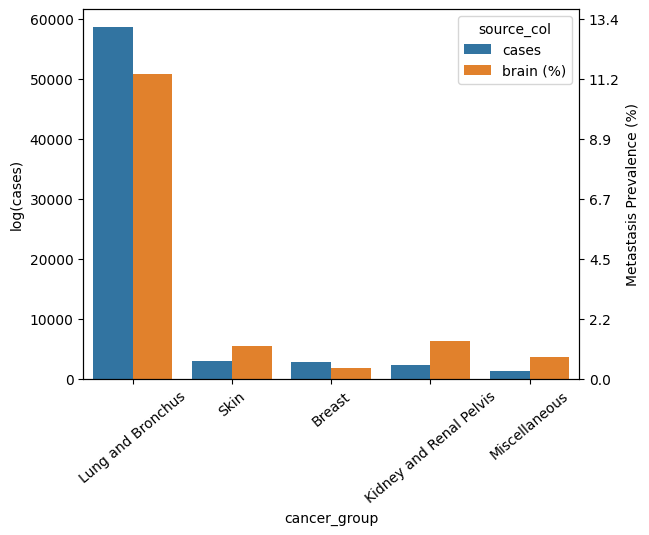

In [15]:
import math

# PREV_COLS = [BRAIN_FIELD, BONE_FIELD, LUNG_FIELD, LIVER_FIELD]
PREV_COLS = [BRAIN_FIELD]

maintable = maintable.sort_values('YES', ascending=False)
test = maintable.head()
test = test.reset_index()
# test['cases'] = test['YES'].apply(math.log)
test['cases'] = test['YES']
test = test[[FEATURE] + ['cases'] + PREV_COLS]
test_melt = pd.melt(test, id_vars=FEATURE, var_name=SRC_COL, value_name=VAL_COL)
# test_melt.head(10)

# Scale the data, just a simple example of how you might determine the scaling
mask = test_melt.source_col.isin(PREV_COLS)
scale = int(test_melt[~mask].value_col.mean()
            /test_melt[mask].value_col.mean())
test_melt.loc[mask, VAL_COL] = test_melt.loc[mask, VAL_COL]*scale

# Plot
import numpy as np 

fig, ax1 = plt.subplots()
g = sns.barplot(x=FEATURE, y=VAL_COL, hue=SRC_COL, data=test_melt, ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=40)
# g.bar_label(g.containers[0], fontsize=10)

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('log(cases)')
ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax2.set_ylabel('Metastasis Prevalence (%)')

# TODO 

plt.show()

CASES

In [145]:
df.head()

,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr
1,137,"2,017.00",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,plasma cell tumors,NO,NO,NO,NO,NO,Plasma cell myeloma
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,Serous carcinoma [+ others]
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NO,Adenoma [+ others]


In [5]:
### CASE LOAD ###
# calculate prevalences per cancer_group.

from util_classes import Settings
from util_funcs import calculate_met_stats

FEATURE = 'cancer_group'
BRAIN_FIELD = 'brain met cases'
BONE_FIELD = 'bone met cases'
LUNG_FIELD = 'lung met cases'
LIVER_FIELD = 'liver met cases'
SRC_COL = 'source_col'
VAL_COL = 'value_col'

n_yes = df[df['brain_met']=='YES'].shape[0]
n_no = df[df['brain_met']=='NO'].shape[0]
# total_odds = n_yes / n_no

s = Settings()
brain_stats = calculate_met_stats(feature=FEATURE, response='brain_met', df=df, cohort_yes=n_yes, cohort_no=n_no)
brain_stats.rename(columns={'YES': BRAIN_FIELD}, inplace=True)
maintable = brain_stats
maintable.head()


,NO,brain met cases,records,prevalence (%),OR_STAT,OR_CI_LOW,OR_CI_HIGH
cancer_group,,,,,,,
"Anus, Anal Canal and Anorectum",19667,22,19689,0.11,0.07,0.04,0.10
Appendix,13603,4,13607,0.03,0.02,0.01,0.05
Bones and Joints,9126,46,9172,0.50,0.30,0.22,0.40
Breast,663355,2769,666124,0.42,0.25,0.24,0.26
CNS,62193,404,62597,0.65,0.39,0.35,0.42


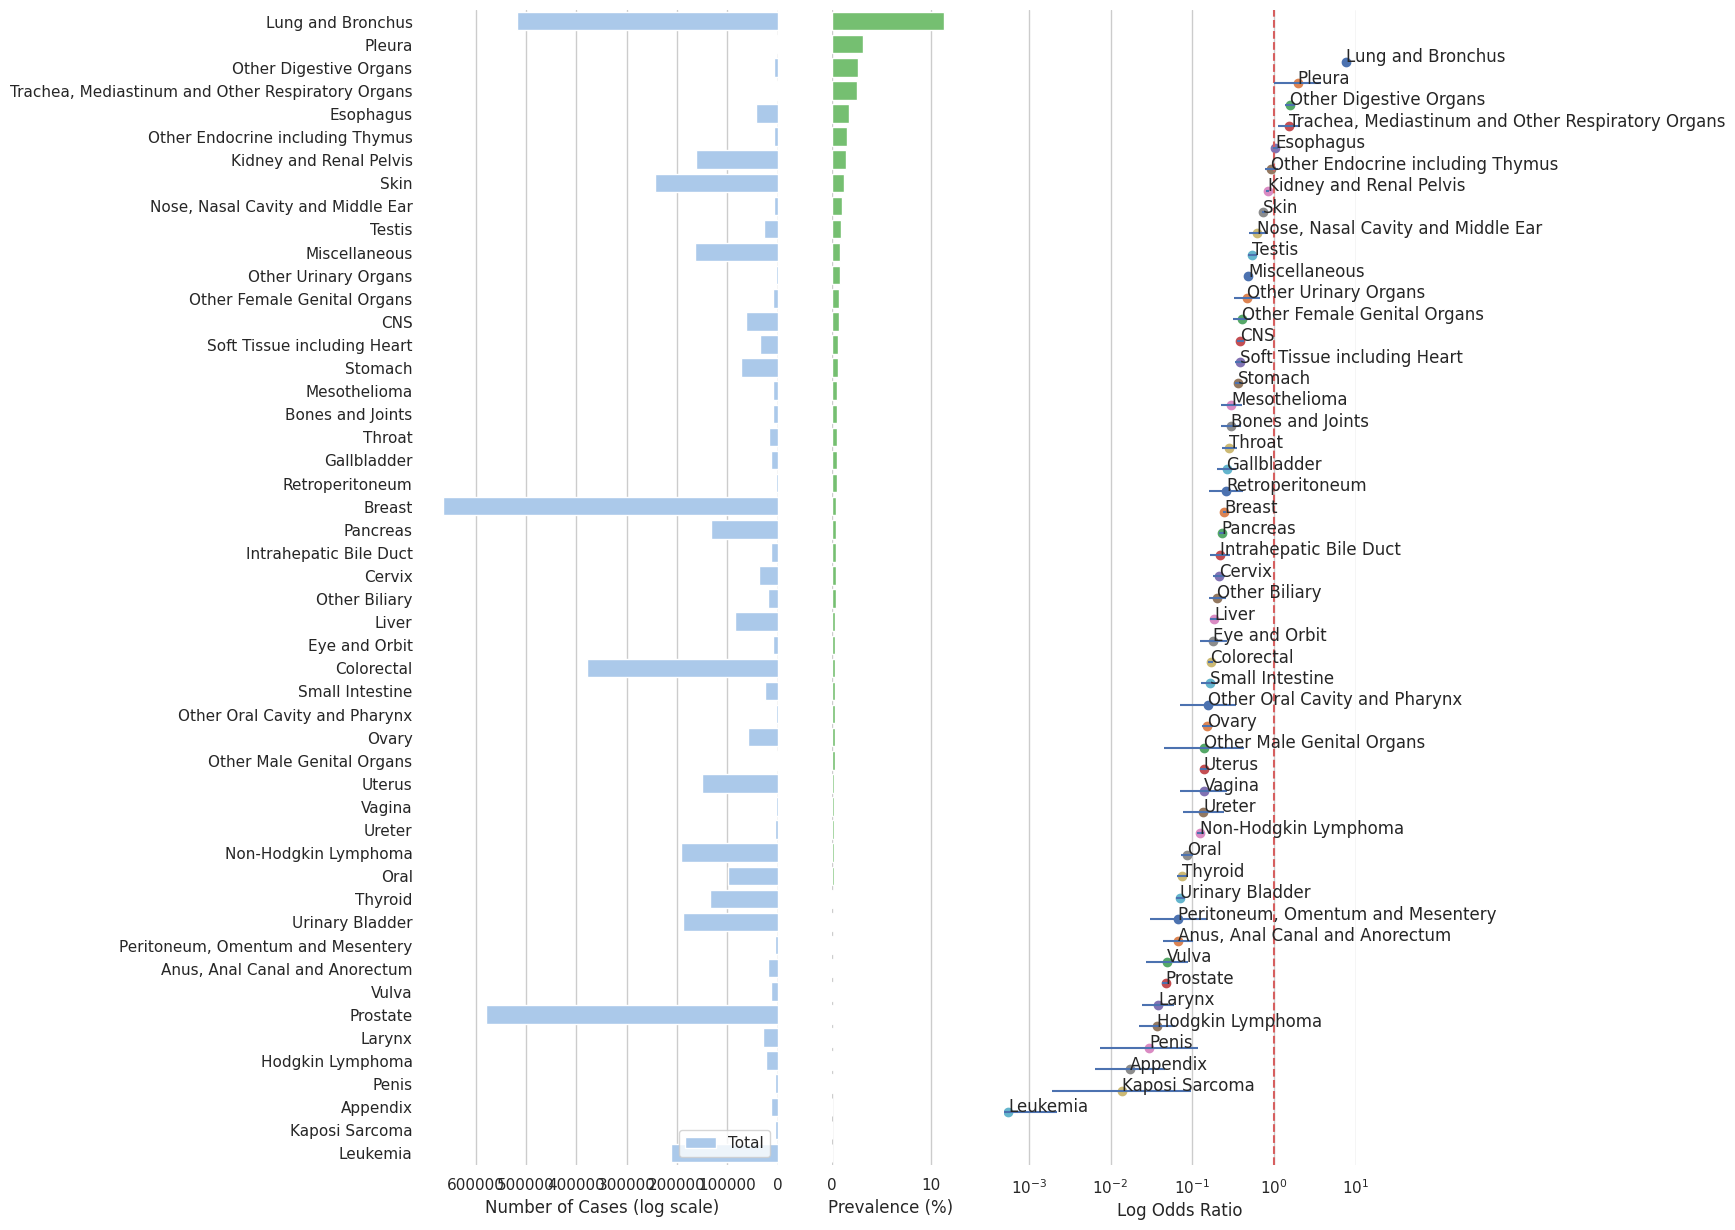

In [18]:
import math

# PREV_COLS = [BONE_FIELD, LUNG_FIELD, LIVER_FIELD]
PREV_COLS = [BRAIN_FIELD]

# test = maintable.sort_values('records', ascending=False)
test = maintable.sort_values('prevalence (%)', ascending=False)
test = test.reset_index()

# theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 15), width_ratios=[3, 1, 3])
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

### LOG CASES SUBPLOT ###
# Plot total cases
sns.set_color_codes("pastel")
g = sns.barplot(x="records", y=FEATURE, data=test, label="Total", color="b", ax=ax1)
# Plot brain met cases
# sns.set_color_codes("muted")
# sns.barplot(x=BRAIN_FIELD, y=FEATURE, data=test, label="Brain Met", color="b", ax=ax1)

# Add a legend and informative axis label
# ax1.set_xscale('log')
ax1.legend(ncol=2, loc="lower right", frameon=True)
ax1.set(ylabel="", xlabel="Number of Cases (log scale)")
ax1.invert_xaxis()
sns.despine(left=True, bottom=True)

### PREVALENCE SUBPLOT ###
test['ref'] = 100
# sns.set_color_codes("pastel")
# sns.barplot(x="ref", y=FEATURE, data=test, label="Total", color="b", ax=ax2)
sns.set_color_codes("muted")
sns.barplot(x="prevalence (%)", y=FEATURE, data=test, label="Total", color="g", ax=ax2, legend=False)
ax2.set_yticklabels([])
ax2.set(ylabel="", xlabel="Prevalence (%)")

### ODDS RATIO SUBPLOT ###
ax3.set_yticks([])
ax3.set_yticklabels([])

ax3.set_yticks([])
# ax3.set_xticks([0, 1, 2])
# ax3.set_xticklabels([1, 10])
ax3.axvline(1, c='r', ls='--')
ax3.set(ylabel="", xlabel="Log Odds Ratio")
nrows = test.shape[0]
for bar, (i, row) in zip(g.containers[0], test.iterrows()):
    # ythick = bar.get_height()
    ypos = nrows - bar.get_y()
    # ax3.hlines(y=ypos, xmin=row['OR_CI_LOW'], xmax=row['OR_CI_HIGH'], solid_capstyle='round')
    ax3.hlines(y=ypos, xmin=row['OR_CI_LOW'], xmax=row['OR_CI_HIGH'])
    ax3.scatter(row["OR_STAT"], ypos, marker='o')
    ax3.text(y=ypos, x=row['OR_STAT'], s=row[FEATURE])
    # print(f'{i}: ctype={row[FEATURE]}; ypos={ypos}; ythick={ythick}; OR={row["OR_STAT"]:0.1f}')
ax3.set_xscale('log')
ax3.set_xlim(0.0005, 10)
plt.show()


            cancer_group       source_col  value_col  scaled_val
0                 Breast          records     666124      666124
1               Prostate          records     580026      580026
2      Lung and Bronchus          records     517738      517738
3             Colorectal          records     378705      378705
4                   Skin          records     242645      242645
5               Leukemia          records     211305      211305
6   Non-Hodgkin Lymphoma          records     192289      192289
7        Urinary Bladder          records     188132      188132
8                 Breast  brain met cases       2769      121836
9               Prostate  brain met cases        460       20240
10     Lung and Bronchus  brain met cases      58591     2578004
11            Colorectal  brain met cases       1065       46860
12                  Skin  brain met cases       2993      131692
13              Leukemia  brain met cases          2          88
14  Non-Hodgkin Lymphoma 

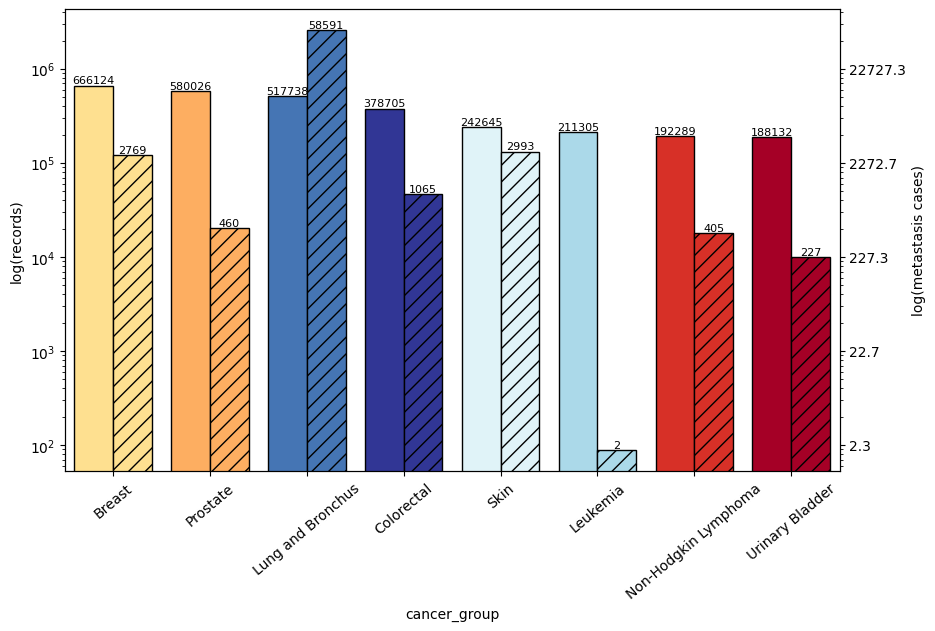

In [107]:
import math

# PREV_COLS = [BONE_FIELD, LUNG_FIELD, LIVER_FIELD]
PREV_COLS = [BRAIN_FIELD]

maintable = maintable.sort_values('records', ascending=False)
test = maintable.head(8)
test = test.reset_index()
test = test[[FEATURE] + ['records'] + PREV_COLS]

test_melt = pd.melt(test, id_vars=[FEATURE], var_name=SRC_COL, value_name=VAL_COL)

# Scale the data, just a simple example of how you might determine the scaling
mask = test_melt.source_col.isin(PREV_COLS)
scale = int(test_melt[~mask].value_col.mean()
            /test_melt[mask].value_col.mean())
test_melt['scaled_val'] = test_melt[VAL_COL]
test_melt.loc[mask, 'scaled_val'] = test_melt.loc[mask, 'scaled_val']*scale
print(test_melt)

# catplot instead?

# Plot
import numpy as np 

fig, ax1 = plt.subplots(figsize=(10, 6))
g = sns.barplot(x=FEATURE, y='scaled_val', hue=SRC_COL, data=test_melt, ax=ax1, errorbar=None, edgecolor='black', legend=False)
g.bar_label(g.containers[0], labels=test_melt.loc[test_melt[SRC_COL] == 'records'][VAL_COL], fontsize=8)
g.bar_label(g.containers[1], labels=test_melt.loc[test_melt[SRC_COL] == BRAIN_FIELD][VAL_COL], fontsize=8)

# texture on secondary bars
palette = ["#fee090", "#fdae61", "#4575b4", "#313695", "#e0f3f8", "#abd9e9", "#d73027", "#a50026"]
for i, container in enumerate(g.containers):
    for j, bar in enumerate(container):
        if i == 1:
            bar.set_hatch('//')
        bar.set_facecolor(palette[j])

# rotate cancer type labels
g.set_xticklabels(g.get_xticklabels(), rotation=40)

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('log(records)')
ax2 = ax1.twinx()
ax1.set_yscale('log')
ax2.set_yscale('log')

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax2.set_ylabel('log(metastasis cases)')

plt.show()

        cancer_group       source_col  value_col  scaled_val
0             Breast          records     666124      666124
1           Prostate          records     580026      580026
2  Lung and Bronchus          records     517738      517738
3         Colorectal          records     378705      378705
4               Skin          records     242645      242645
5             Breast  brain met cases       2769       99684
6           Prostate  brain met cases        460       16560
7  Lung and Bronchus  brain met cases      58591     2109276
8         Colorectal  brain met cases       1065       38340
9               Skin  brain met cases       2993      107748


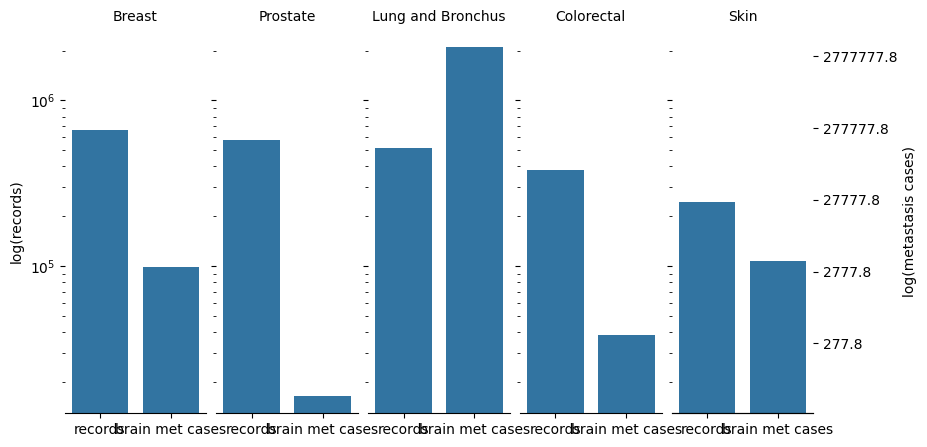

In [83]:
import math

# PREV_COLS = [BONE_FIELD, LUNG_FIELD, LIVER_FIELD]
PREV_COLS = [BRAIN_FIELD]

maintable = maintable.sort_values('records', ascending=False)
test = maintable.head()
test = test.reset_index()
test = test[[FEATURE] + ['records'] + PREV_COLS]

test_melt = pd.melt(test, id_vars=FEATURE, var_name=SRC_COL, value_name=VAL_COL)

# Scale the data, just a simple example of how you might determine the scaling
mask = test_melt.source_col.isin(PREV_COLS)
scale = int(test_melt[~mask].value_col.mean()
            /test_melt[mask].value_col.mean())
test_melt['scaled_val'] = test_melt[VAL_COL]
test_melt.loc[mask, 'scaled_val'] = test_melt.loc[mask, 'scaled_val']*scale
print(test_melt)

# catplot instead

# # Plot
# import numpy as np 

# fig, ax1 = plt.subplots()
# # g = sns.barplot(x=FEATURE, y=VAL_COL, hue=SRC_COL, data=test_melt, ax=ax1, log_scale=True)
# g = sns.barplot(x=FEATURE, y='scaled_val', hue=SRC_COL, data=test_melt, ax=ax1)
# g.set_xticklabels(g.get_xticklabels(), rotation=40)
# # g.bar_label(g.containers[0], labels=test_melt.loc[test_melt[SRC_COL] == 'records'][VAL_COL], fontsize=8)
# # g.bar_label(g.containers[1], labels=test_melt.loc[test_melt[SRC_COL] == BRAIN_FIELD][VAL_COL], fontsize=8)

# # Create a second y-axis with the scaled ticks
# ax1.set_ylabel('log(records)')
# ax2 = ax1.twinx()
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# # Ensure ticks occur at the same positions, then modify labels
# ax2.set_ylim(ax1.get_ylim())
# ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
# ax2.set_ylabel('log(metastasis cases)')

g = sns.catplot(
    data=test_melt, x=SRC_COL, y='scaled_val', col=FEATURE,
    kind="bar", height=4, aspect=.8,
)

ax_right = g.axes_dict['Skin'].twinx()
ax_right.set_ylim(ax1.get_ylim())
ax_right.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax_right.set_ylabel('log(metastasis cases)')

g.set_axis_labels("", "")
g.axes_dict['Breast'].set_ylabel('log(records)')
g.axes_dict['Breast'].set_yscale('log')

g.despine(left=True)
g.set_titles("{col_name}")

# g.set_xticklabels(["Men", "Women", "Children"])
# g.set(yticks=[])

g.figure.set_size_inches(8,5)
plt.show()

In [58]:
df = sns.load_dataset("titanic")
df
# g = sns.catplot(
#     data=df, x="who", y="survived", col="class",
#     kind="bar", height=4, aspect=.6, errorbar=None
# )
# g.set_axis_labels("", "Survival Rate")
# g.set_xticklabels(["Men", "Women", "Children"])
# g.set_titles("{col_name} {col_var}")
# g.set(ylim=(0, 1))
# g.despine(left=True)
# plt.show()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.00,1,0,7.25,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.00,1,0,71.28,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.00,0,0,7.92,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.00,1,0,53.10,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.00,0,0,8.05,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.00,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.00,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.00,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
# TODO handle in barplot
# print('\nRemoving records for brain primaries')
# irecords = df.shape[0]
# df = df[df['cancer_type']!='Brain']
# print(f'removed {irecords - df.shape[0]} records')

# print('\nRemoving records for CNS cancer_group')
# irecords = df.shape[0]
# df = df[df['cancer_group']!='CNS']
# print(f'removed {irecords - df.shape[0]} records')

In [ ]:
### TEST DATA ###
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

columns = ["labels", "values_a", "values_b", "values_x", "values_y"]
test_data = pd.DataFrame.from_records([("date1", 1, 3, 150, 170),\
                                       ("date2", 2, 6, 200, 180)],\
                                       columns=columns)

test_data_melted = pd.melt(test_data, id_vars=columns[0],\
                           var_name="source", value_name="value_numbers")


In [ ]:
### TEST PLOTTING ###

# Scale the data, just a simple example of how you might determine the scaling
mask = test_data_melted.source.isin(['values_a', 'values_b'])
scale = int(test_data_melted[~mask].value_numbers.mean()
            /test_data_melted[mask].value_numbers.mean())
test_data_melted.loc[mask, 'value_numbers'] = test_data_melted.loc[mask, 'value_numbers']*scale

# Plot
fig, ax1 = plt.subplots()
g = sns.barplot(x=columns[0], y="value_numbers", hue="source",\
                data=test_data_melted, ax=ax1)

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('X and Y')
ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax2.set_ylabel('A and B')

plt.show()